# **Airbnbs in Tokyo: Analysis and Recommendations**

![title image](https://www.marketingweek.com/content/uploads/2014/11/Brand_Case_Study3.gif)

# **Business Understanding**

Airbnb has become a major player in the global travel industry, offering an alternative to traditional hotel accommodations by allowing property owners to rent out their spaces to travelers. Airbnb's revenue is one of the highest among competitors, **$8 Billion**. With the rise in international travel, Airbnb is looking to expand its presence in key international markets.

One such market is **Japan**, where the government is keen on promoting tourism and cross-cultural experiences. Japan was one of the last countries to lift Covid travel restrictions in May 2023. Number of visitors to the country reached **2.5 million** in October, 2023 compared to **2.4 million** in 2019. To this end, the Japanese government has entered into a partnership with Airbnb to increase the platform's presence in the country, with a specific focus on Tokyo. This collaboration aims to provide more accommodation options for tourists, foster local economic growth by tapping into the sharing economy, and increase revenue for the platform. 

# **Business Problem** 
The primary business problem centers on identifying the key factors that contribute to the popularity of properties in Tokyo. These were assessed based on amenities offered, user review, price of the property and user ratings. This allows Airbnb to model their growth behind what the Japanese government is trying to promote. 

This project also aims to to develop a recommendation system by increasing the visibility and utilization of Airbnb's existing housing inventory.The recommendation system will guide new users in rating properties and receive tailored recommendations based on their preferences.

# **Data Overview**
* **Datasets:** 
    * Listings provides information on the attributes of the property.
    * Reviews provides information of the user review for the property.
* **Source:** [Inside Airbnb](http://insideairbnb.com/get-the-data)

* **Limitations**
    * User reviews can be biased. Some guests may be more likely to leave reviews based on extreme experiences (either very positive or very negative), leading to a potential bias in the sentiment of reviews
    * Limited historical data due to Covid-19 impact on bookings
    * Listings information can vary in quality. Some listings may have high-quality descriptions and images, while others may lack important details.
* **Filters**
    * Listings with a minimum of 10 reviews
    * May 1, 2023

In [54]:
# Necessary Imports
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import surprise
from surprise.prediction_algorithms import *
from surprise import accuracy, Dataset, Reader, BaselineOnly

from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, NMF
from surprise.model_selection import GridSearchCV

from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
import nltk
import re
import ast
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

## Reading in datasets from zipped file
* Reviews
* Listings

In [2]:
zip_file_path = 'data/zipped_data.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('data/extracted_files')

In [3]:
reviews_df = pd.read_csv('data/extracted_files/reviews.csv')

In [4]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451682 entries, 0 to 451681
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     451682 non-null  int64 
 1   id             451682 non-null  int64 
 2   date           451682 non-null  object
 3   reviewer_id    451682 non-null  int64 
 4   reviewer_name  451681 non-null  object
 5   comments       451638 non-null  object
dtypes: int64(3), object(3)
memory usage: 20.7+ MB


In [5]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,197677,554285,2011-09-21,1002142,Pablo,Couldn’t get any better!\r<br/>\r<br/>The apar...
1,197677,627651,2011-10-14,1031940,Ana & Ricardo,The apartment is bigger than it looks in the p...
2,197677,733040,2011-11-21,1097040,Samuel,The appartement is perfect for a couple! It is...
3,197677,755841,2011-11-30,1183674,Lisa,We had a terrific stay at Yoshimi and Marek's ...
4,197677,852938,2012-01-09,1538004,Langan,We loved our stay at the Oshiage Holiday Apart...


In [6]:
listings = pd.read_csv('data/extracted_files/listings.csv')

In [7]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12234 entries, 0 to 12233
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            12234 non-null  int64  
 1   listing_url                                   12234 non-null  object 
 2   scrape_id                                     12234 non-null  int64  
 3   last_scraped                                  12234 non-null  object 
 4   source                                        12234 non-null  object 
 5   name                                          12234 non-null  object 
 6   description                                   12234 non-null  object 
 7   neighborhood_overview                         8400 non-null   object 
 8   picture_url                                   12234 non-null  object 
 9   host_id                                       12234 non-null 

In [8]:
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,city scrape,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
1,5240174,https://www.airbnb.com/rooms/5240174,20230924051543,2023-09-24,previous scrape,Rental unit in Shibuya-ku · ★4.52 · Studio · 1...,Minimalist simple grey-color interior room. My...,NaN,https://a0.muscache.com/pictures/b0b55fef-80cb...,24477517,...,4.83,4.29,4.30,M130005396,t,4,4,0,0,1.89
2,5262640,https://www.airbnb.com/rooms/5262640,20230924051543,2023-09-24,city scrape,Rental unit in Nakano-ku · ★4.80 · 1 bedroom ·...,It takes 5 min walk to Fujimidai Sta.. You can...,No smoking in the room<br />No outdoor shoes a...,https://a0.muscache.com/pictures/281f8d6f-eb4a...,17736560,...,4.87,4.61,4.77,Hotels and Inns Business Act | 中野区保健所 | 30中環生環...,f,9,9,0,0,0.59
3,776070,https://www.airbnb.com/rooms/776070,20230924051543,2023-09-24,city scrape,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,...,4.98,4.84,4.91,M130000243,f,1,0,1,0,1.88
4,905944,https://www.airbnb.com/rooms/905944,20230924051543,2023-09-24,city scrape,Rental unit in Shibuya · ★4.77 · 2 bedrooms · ...,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/miso/Hosting-...,4847803,...,4.91,4.78,4.78,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,5,5,0,0,1.52


# Exploratory Data Analysis and Create master dataset

* Creating a master dataframe

In [9]:
merged_df = pd.merge(reviews_df, listings, left_on='listing_id', right_on='id', how='inner')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451682 entries, 0 to 451681
Data columns (total 81 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   listing_id                                    451682 non-null  int64  
 1   id_x                                          451682 non-null  int64  
 2   date                                          451682 non-null  object 
 3   reviewer_id                                   451682 non-null  int64  
 4   reviewer_name                                 451681 non-null  object 
 5   comments                                      451638 non-null  object 
 6   id_y                                          451682 non-null  int64  
 7   listing_url                                   451682 non-null  object 
 8   scrape_id                                     451682 non-null  int64  
 9   last_scraped                                  45

In [10]:
merged_df.head()

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,id_y,listing_url,scrape_id,last_scraped,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,554285,2011-09-21,1002142,Pablo,Couldn’t get any better!\r<br/>\r<br/>The apar...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
1,197677,627651,2011-10-14,1031940,Ana & Ricardo,The apartment is bigger than it looks in the p...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
2,197677,733040,2011-11-21,1097040,Samuel,The appartement is perfect for a couple! It is...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
3,197677,755841,2011-11-30,1183674,Lisa,We had a terrific stay at Yoshimi and Marek's ...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
4,197677,852938,2012-01-09,1538004,Langan,We loved our stay at the Oshiage Holiday Apart...,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19


In [11]:
merged_df.isna().sum()

listing_id                                      0
id_x                                            0
date                                            0
reviewer_id                                     0
reviewer_name                                   1
                                               ..
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
reviews_per_month                               0
Length: 81, dtype: int64

* Some of the reviews are from 2011, I only want the recent ones

In [12]:
merged_df['date'].value_counts()

date
2023-07-30    931
2023-08-14    850
2023-07-17    848
2023-05-06    832
2023-05-07    829
             ... 
2014-07-03      1
2013-12-15      1
2014-04-12      1
2014-01-10      1
2011-09-21      1
Name: count, Length: 3682, dtype: int64

* Checking num_of_reviews column. Will need to filter this by at least 10 reviews

In [13]:
merged_df['listing_id'].value_counts()

listing_id
27750681              2023
49084102               971
44125369               966
44637473               782
25377337               779
                      ... 
41653901                 1
41805631                 1
924340394945850701       1
41573195                 1
983031277017558192       1
Name: count, Length: 10776, dtype: int64

In [14]:
merged_df["listing_id"].nunique()

10776

# Data Processing

In [12]:
# Convert date column to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Filter by date since May 1, 2023
merged_df = merged_df[merged_df['date'] >= '2023-05-01']

# Filter by number of reviews
merged_df = merged_df[merged_df['number_of_reviews'] > 10]

# drop unnecessary columns
col = ['id_x', 'id_y', 'source', 'host_id', 'host_name', 'calculated_host_listings_count', 'availability_365', 'host_id', 'host_url',
       'host_listings_count', 'host_total_listings_count', 'scrape_id', 'last_scraped',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_group_cleansed',  'minimum_nights',
       'calendar_updated', 
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',
       'first_review', 'last_review',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'license', 'instant_bookable',
       'calculated_host_listings_count', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
       'reviews_per_month', 'host_since', 'host_location', 'host_thumbnail_url', 'host_picture_url','host_neighbourhood',
       'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'                                           
       ]

merged_df.drop(col, axis=1, inplace=True)

# rename columns
merged_df.rename(columns={'review_scores_rating': 'rating', 'accomodates': 'guest_limit', 'neighbourhood_cleansed': 'neighborhood'}, inplace=True)


In [13]:
# sanity check
merged_df = merged_df.reset_index(drop=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74975 entries, 0 to 74974
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   listing_id              74975 non-null  int64         
 1   date                    74975 non-null  datetime64[ns]
 2   reviewer_id             74975 non-null  int64         
 3   reviewer_name           74975 non-null  object        
 4   comments                74965 non-null  object        
 5   listing_url             74975 non-null  object        
 6   name                    74975 non-null  object        
 7   description             74975 non-null  object        
 8   neighborhood_overview   54749 non-null  object        
 9   picture_url             74975 non-null  object        
 10  neighborhood            74975 non-null  object        
 11  latitude                74975 non-null  float64       
 12  longitude               74975 non-null  float6

## Save as CSV and Export zip file

In [14]:
# Rename the dataframe to appropriate name and save cleaned dataset as CSV
df = merged_df

In [92]:
#df.to_csv('data/extracted_files/airbnb_listings.csv', index=False)

In [94]:
#with zipfile.ZipFile('data/airbnb_listings.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    #zipf.write('data/extracted_files/airbnb_listings.csv', arcname='airbnb_listings.csv')

In [77]:
#df = pd.read_csv('data/extracted_files/airbnb_listings.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74975 entries, 0 to 74974
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   listing_id              74975 non-null  int64         
 1   date                    74975 non-null  datetime64[ns]
 2   reviewer_id             74975 non-null  int64         
 3   reviewer_name           74975 non-null  object        
 4   comments                74965 non-null  object        
 5   listing_url             74975 non-null  object        
 6   name                    74975 non-null  object        
 7   description             74975 non-null  object        
 8   neighborhood_overview   54749 non-null  object        
 9   picture_url             74975 non-null  object        
 10  neighborhood            74975 non-null  object        
 11  latitude                74975 non-null  float64       
 12  longitude               74975 non-null  float6

In [96]:
df.head()

,listing_id,date,reviewer_id,reviewer_name,comments,listing_url,name,description,neighborhood_overview,picture_url,...,bathrooms_text,bedrooms,beds,amenities,price,has_availability,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,rating
0,197677,2023-05-05,80161764,Sabrina,"Friendly welcome, well equiped accomodation. E...",https://www.airbnb.com/rooms/197677,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,...,1 bath,1.0,2.0,"[""Microwave"", ""Hangers"", ""Kitchen"", ""Fire exti...","$12,000.00",t,174,8,0,4.77
1,197677,2023-05-30,14533360,Liang-Pin,Marek is a very friendly host. He was very kin...,https://www.airbnb.com/rooms/197677,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,...,1 bath,1.0,2.0,"[""Microwave"", ""Hangers"", ""Kitchen"", ""Fire exti...","$12,000.00",t,174,8,0,4.77
2,197677,2023-08-13,390831971,Ainsley,It is a nice and peaceful location and totally...,https://www.airbnb.com/rooms/197677,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,...,1 bath,1.0,2.0,"[""Microwave"", ""Hangers"", ""Kitchen"", ""Fire exti...","$12,000.00",t,174,8,0,4.77
3,776070,2023-05-19,20824347,Ikuko,Keiさんのご家族はとても仲良しで、自然体で受け入れてくださり<br/>とても居心地の良い雰...,https://www.airbnb.com/rooms/776070,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,...,1 shared bath,NaN,1.0,"[""Luggage dropoff allowed"", ""Private entrance""...","$8,902.00",t,248,18,1,4.98
4,776070,2023-05-28,275284916,Jean-Daniel,It is an amazing place to stay with a japanese...,https://www.airbnb.com/rooms/776070,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,...,1 shared bath,NaN,1.0,"[""Luggage dropoff allowed"", ""Private entrance""...","$8,902.00",t,248,18,1,4.98


# **Visualizations**

### **Top 10 Properties distribution**

In [33]:
df['property_type'].value_counts()

property_type
Entire rental unit                    39828
Entire home                            9512
Room in boutique hotel                 2990
Room in hotel                          2878
Private room in rental unit            2712
Private room in home                   2692
Entire condo                           2574
Room in aparthotel                     2437
Entire serviced apartment              2196
Private room in hostel                 1256
Entire villa                            791
Room in hostel                          776
Private room in serviced apartment      643
Shared room in hostel                   552
Shared room in hotel                    375
Entire loft                             317
Private room in guesthouse              213
Shared room in ryokan                   201
Private room in hut                     194
Shared room in rental unit              172
Private room in condo                   168
Hut                                     152
Room in serviced a

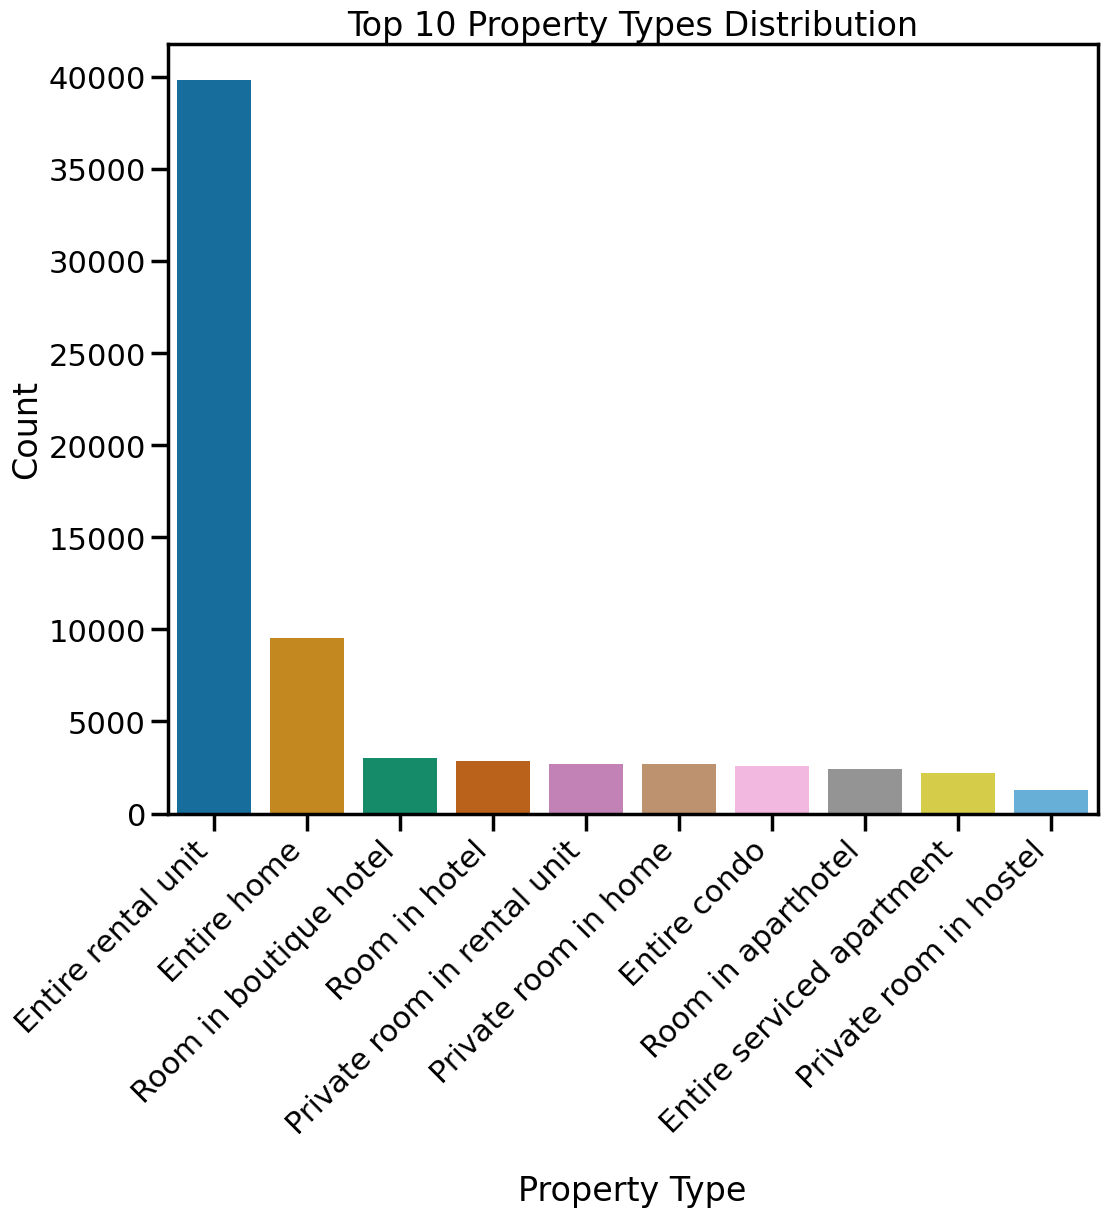

In [43]:
# Plot of Top 10 property_type
top10_property_types = df['property_type'].value_counts().nlargest(10)

sns.set_palette("colorblind")

plt.figure(figsize=(12, 10))

sns.barplot(x=top10_property_types.index, y=top10_property_types.values)

plt.title('Top 10 Property Types Distribution')
plt.xlabel('Property Type', labelpad=25)
plt.ylabel('Total Count')
plt.xticks(rotation=45, ha='right')  
plt.show()


### **Distribution of Room Types**

In [35]:
df["room_type"].value_counts()

room_type
Entire home/apt    57570
Private room       14274
Shared room         1569
Hotel room          1562
Name: count, dtype: int64

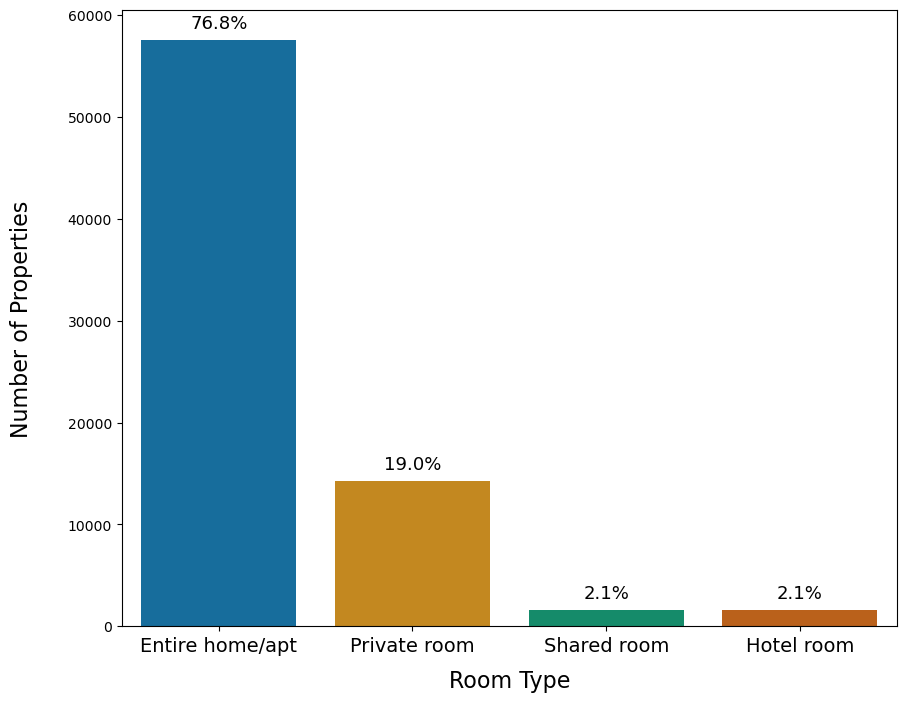

In [189]:
# Plot of Distribution of room_type
plt.figure(figsize=(10,8))
ax = sns.countplot(x='room_type', data=df, palette='colorblind')

plt.xlabel('Room Type', labelpad=10, fontsize=16)
plt.ylabel('Number of Properties', labelpad=25, fontsize=16)
plt.xticks(fontsize=14)

# Adding percentages above the bars
total = len(df['room_type'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + (0.01 * total)
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=13, color='black')

plt.show()


### **Distribution of room_type with rating score above 4.5**

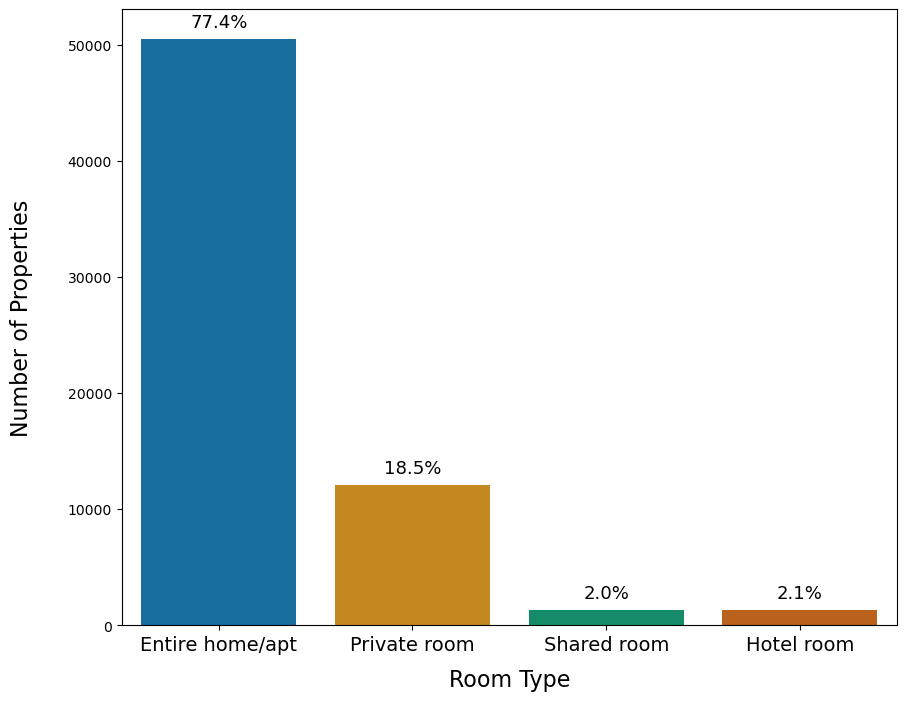

In [194]:
# Plot for room_type with rating above 4.5
test1 = df[df['rating'] > 4.5]

plt.figure(figsize=(10, 8))
ax = sns.countplot(x='room_type', data=test1, palette='colorblind')

plt.xlabel('Room Type', labelpad=10, fontsize=16)
plt.ylabel('Number of Properties', labelpad=25, fontsize=16)
plt.xticks(fontsize=14)

# Adding percentages above the bars
total = len(test1['room_type'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + (0.01 * total)
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=13, color='black')

plt.show()

In [36]:
room_type_counts = df['room_type'].value_counts()

# Calculate percentage
room_type_percentage = (room_type_counts / room_type_counts.sum()) * 100
room_type_percentage


room_type
Entire home/apt    76.785595
Private room       19.038346
Shared room         2.092698
Hotel room          2.083361
Name: count, dtype: float64

### **Distribution of Rating Scores**

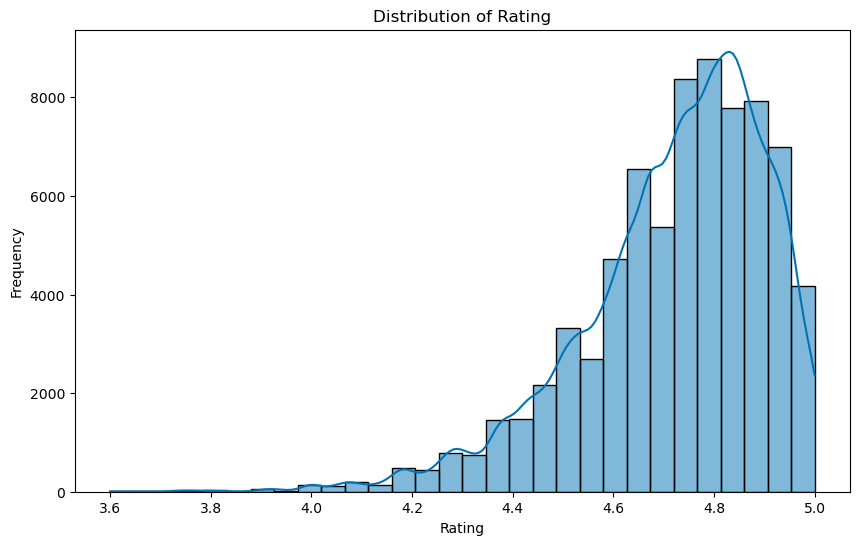

In [26]:
# Histogram of rating scores
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=30, kde=True)

plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.show()

### **Box plot of review scores rating by room type**

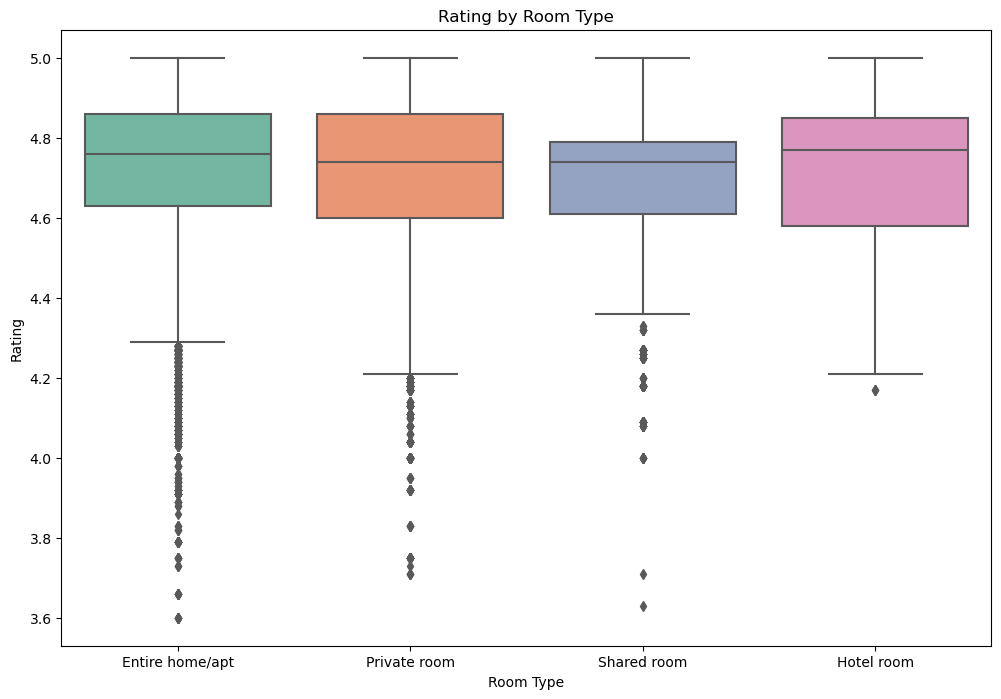

In [27]:
# Box plot of review scores by room_type
plt.figure(figsize=(12, 8))
sns.boxplot(x='room_type', y='rating', data=df, palette='Set2')

plt.title('Rating by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Rating')

plt.show()

### **Converting price per night column from Japanese Yen to USD**

In [31]:
df['price']

0        $12,000.00
1        $12,000.00
2        $12,000.00
3         $8,902.00
4         $8,902.00
            ...    
74970    $27,714.00
74971    $27,714.00
74972    $27,714.00
74973    $27,714.00
74974    $27,714.00
Name: price, Length: 74975, dtype: object

In [130]:
# Clean and convert 'price' column to numeric format
df['price'] = pd.to_numeric(df['price'].replace('[^\d.]', '', regex=True), errors='coerce')

# Assuming exchange rate of 1 JPY = 0.0091 USD
exchange_rate = 0.0091

df['price_in_usd'] = df['price'] * exchange_rate

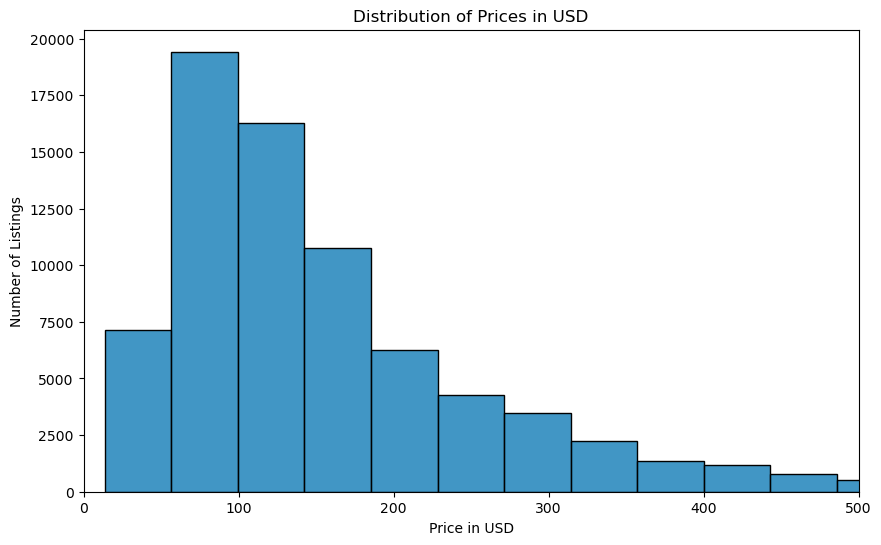

In [159]:
# Plot for distribution of prices in USD (limit to 500)
plt.figure(figsize=(10, 6))
sns.histplot(df['price_in_usd'], bins=50)
plt.xlim(0, 500)
plt.title('Distribution of Prices in USD')
plt.xlabel('Price in USD')
plt.ylabel('Number of Listings')
plt.show()

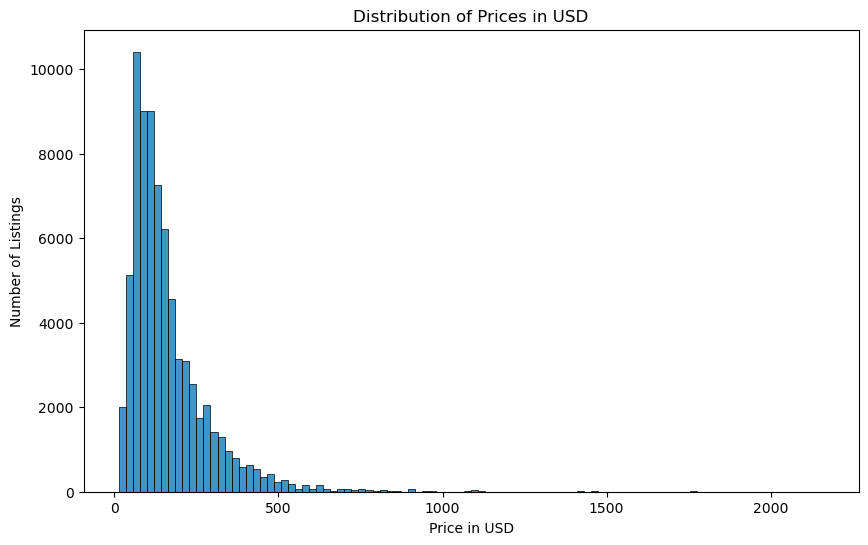

In [160]:
# Plot price in usd for all listings 
plt.figure(figsize=(10, 6))
sns.histplot(df['price_in_usd'], bins=100)
plt.title('Distribution of Prices in USD')
plt.xlabel('Price in USD')
plt.ylabel('Number of Listings')
plt.show()

### **Focusing on prices for Entire homes or apartments**

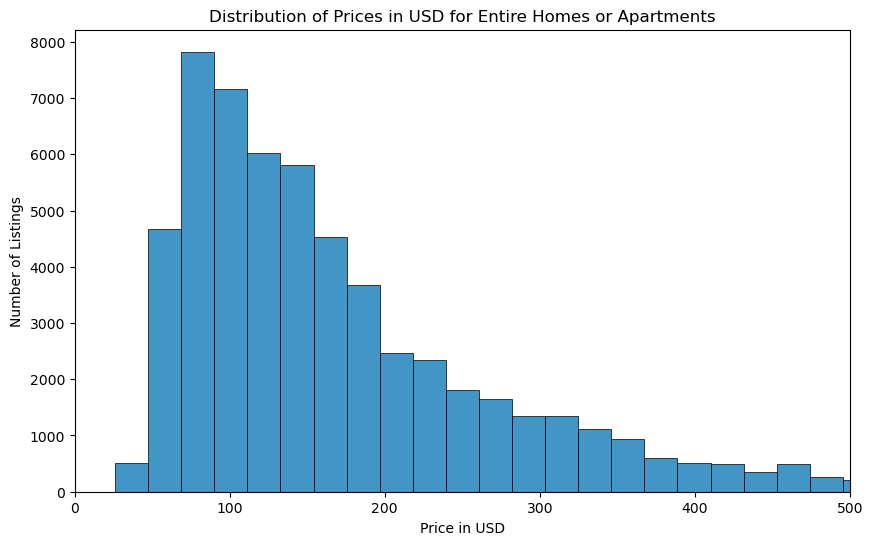

In [164]:
# Filter the DataFrame for rows where room_type is 'Entire home/apt'
entire_home_df = df[df['room_type'] == 'Entire home/apt']

plt.figure(figsize=(10, 6))
sns.histplot(entire_home_df['price_in_usd'], bins=100)
plt.xlim(0,500)
plt.title('Distribution of Prices in USD for Entire Homes or Apartments')
plt.xlabel('Price in USD')
plt.ylabel('Number of Listings')
plt.show()


### **Plot of review scores and price**

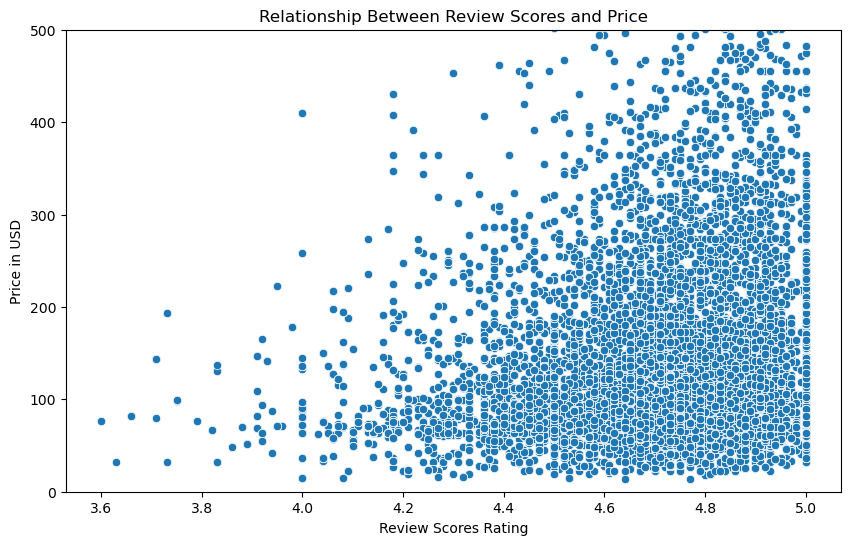

In [135]:
# Scatterplot of Rating vs price_in_usd
# Setting the limit of price to $500
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='price_in_usd', data=df)
plt.ylim(0,500)
plt.title('Relationship Between Review Scores and Price')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price in USD')
plt.show()

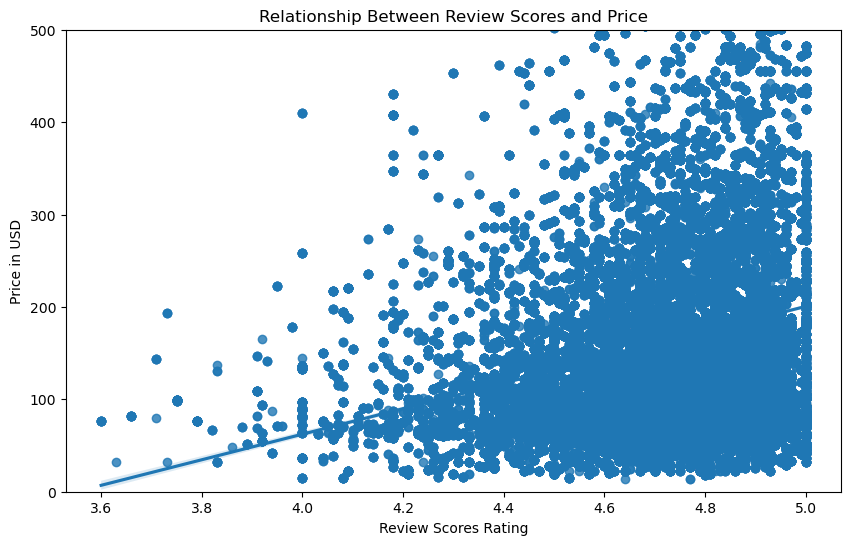

In [139]:
# Regression plot for rating and price
# Setting the limit for y-axis to focus on a specific price range
plt.figure(figsize=(10, 6))
sns.regplot(x='rating', y='price_in_usd', data=df)
plt.ylim(0, 500) 
plt.title('Relationship Between Review Scores and Price')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price in USD')
plt.show()

# Finding most reviewed properties

In [196]:
popular = df['listing_id'].value_counts()
popular

listing_id
27750681              363
44125369              340
847456265351637680    269
49084102              244
50381026              178
                     ... 
52679208                1
43407221                1
30762349                1
23692393                1
26171785                1
Name: count, Length: 6657, dtype: int64

In [195]:
popular.nunique()

92

In [98]:
# Filter the DataFrame to show listings where the same reviewer reviewed multiple properties
duplicated_reviewers = df[df.duplicated('reviewer_id', keep=False)]

# Display the relevant columns for these listings
relevant_columns = ['reviewer_id', 'listing_id', 'number_of_reviews', 'rating']
result = duplicated_reviewers[relevant_columns].sort_values(by='reviewer_id')
result.head()

,reviewer_id,listing_id,number_of_reviews,rating
4989,51865,16409316,240,4.85
58897,51865,628785146348461723,19,4.89
32945,56895,40093874,53,4.83
47211,56895,47151937,46,4.96
23172,82275,33697267,83,4.83


In [48]:
# Looking at unique reviews per listing 
unique_reviews_per_listing = df.groupby('listing_id')['comments'].nunique().reset_index()

# Sort the DataFrame by the count of unique reviews in descending order
unique_reviews_per_listing = unique_reviews_per_listing.sort_values(by='comments', ascending=False)

print(unique_reviews_per_listing)

              listing_id  comments
1156            27750681       363
3845            44125369       339
6294  847456265351637680       268
4471            49084102       243
4617            50381026       178
...                  ...       ...
3287            41600947         1
3272            41566184         1
1009            26498117         1
1013            26533070         1
3535            42796389         1

[6657 rows x 2 columns]


In [41]:
# find the maximum number of reviews for each listing_id
max_review_counts = df.groupby('listing_id')['number_of_reviews'].max()

# Find the listing with the highest number of reviews
most_reviewed_listing = max_review_counts.idxmax()
most_reviews = max_review_counts.max()

print(f"The most reviewed property is {most_reviewed_listing} with {most_reviews} reviews.")

The most reviewed property is 27750681 with 2023 reviews.


### **Creating list of top 10 listings with most reviews and use this for preprocessing**

In [50]:
# Find the maximum number of reviews for each listing_id
max_review_counts_list = df.groupby('listing_id')['number_of_reviews'].max()

# Sort the listings by the number of reviews in descending order
sorted_listings = max_review_counts_list.sort_values(ascending=False)

# Select the top 10 or 20 listings
top_10_listings = sorted_listings.head(10)
top_20_listings = sorted_listings.head(20)

# Convert the top 10 listing IDs to a list
top_10_listing_ids = top_10_listings.index.tolist()

# Filter the original DataFrame for these top 10 IDs
top_10_listings_details = df[df['listing_id'].isin(top_10_listing_ids)]

# Since the same listing_id can appear multiple times in df, drop duplicates
top_10_listings_details = top_10_listings_details.drop_duplicates(subset='listing_id')

# Display the detailed information for these top 10 listings
print("Detailed columns of top 10 most reviewed properties:")
top_10_listings_details

Detailed columns of top 10 most reviewed properties:


,listing_id,date,reviewer_id,reviewer_name,comments,listing_url,name,description,neighborhood_overview,picture_url,...,bathrooms_text,bedrooms,beds,amenities,price,has_availability,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,rating
697,4050925,2023-05-02,421642071,Farkvam,Great stay and will definitely be back ! Thank...,https://www.airbnb.com/rooms/4050925,Home in Taito city · ★4.94 · 2 bedrooms · 1 bath,<b>The space</b><br />-pick-up service 9 guest...,NaN,https://a0.muscache.com/pictures/50965406/7da8...,...,1 bath,2.0,NaN,"[""Luggage dropoff allowed"", ""Free washer \u201...","$40,000.00",t,547,57,7,4.94
11140,25377337,2023-05-03,227130046,Robert,"Good place, very cozy and near station",https://www.airbnb.com/rooms/25377337,Boutique hotel in 中央区 · ★4.78 · 1 bedroom · 3 ...,❇︎Sales have been suspended since May due to r...,Tokyo Central Cruising within a 20-minute walk...,https://a0.muscache.com/pictures/5fbf88f8-9eb5...,...,1 private bath,1.0,3.0,"[""Luggage dropoff allowed"", ""Dedicated workspa...","$29,755.00",t,779,74,2,4.78
11686,25924772,2023-05-04,44038055,Pan & Aditya,Perfect place for a short stay. Well kept and ...,https://www.airbnb.com/rooms/25924772,Hostel in Taitō-ku · ★4.68 · 1 bedroom · 36 be...,"Set in Tokyo, 1.1 km from Sensoji Temple, Host...",Hostel Kura offers the best location in Tokyo ...,https://a0.muscache.com/pictures/1fc14b5b-8582...,...,4 shared baths,1.0,36.0,"[""Fire extinguisher"", ""Essentials"", ""Shampoo"",...","$5,571.00",t,535,127,5,4.68
13646,27750681,2023-05-01,45963798,Tess,"Overall a great stay. Excellent location, Davi...",https://www.airbnb.com/rooms/27750681,Rental unit in Tokyo · ★4.67 · 1 bedroom · 2 b...,Located in the heart of the city with close ac...,Shinjuku is an exciting and vibrant neighborho...,https://a0.muscache.com/pictures/306813ea-f2e0...,...,1 bath,1.0,2.0,"[""Luggage dropoff allowed"", ""Dedicated workspa...","$15,631.00",t,2023,873,56,4.67
42405,44125369,2023-05-01,275676896,Alfonso De Andres,The location is amazing. The staff is super he...,https://www.airbnb.com/rooms/44125369,Boutique hotel in Taito City · ★4.67 · 1 bedro...,"・Spatial design with the motif of ""MANGA"" whic...",Surrounding spots *<br />Edo Shitamachi Tradit...,https://a0.muscache.com/pictures/f8e4cb43-8cd9...,...,1 private bath,1.0,2.0,"[""Books and reading material"", ""Luggage dropof...","$13,243.00",t,966,909,43,4.67
43315,44637473,2023-05-01,63562204,Blair,Great place for our family to stay. Comfortabl...,https://www.airbnb.com/rooms/44637473,Boutique hotel in 新宿区 · ★4.83 · 1 bedroom · 4 ...,1フロアに1室の贅沢設計。<br />恋人・夫婦、特別な人とのご利用におすすめです。<br ...,大正、昭和の名立たる文人たちがこよなく愛し、住み継いできた神楽坂。今でも歴史を感じる街並みの...,https://a0.muscache.com/pictures/c576c785-1d3e...,...,1 private bath,1.0,4.0,"[""Luggage dropoff allowed"", ""Dedicated workspa...","$30,326.00",t,782,268,16,4.83
49101,49084102,2023-05-03,382384592,Fajri,"Large of room, I bring 3 kiddos there, kitchen...",https://www.airbnb.com/rooms/49084102,Serviced apartment in Edogawa City · ★4.83 · S...,"June 2021, GRAND OPENING！<br />✅KASAI Sta.➡ 3m...",◆3min from Kasai Sta.<br />◆About 30min to pop...,https://a0.muscache.com/pictures/miso/Hosting-...,...,1 bath,NaN,3.0,"[""Microwave"", ""Hangers"", ""Induction stove"", ""B...","$7,429.00",t,971,536,39,4.83
50075,49470166,2023-05-01,175049089,Michelle,Very convenient location in a quiet neighborho...,https://www.airbnb.com/rooms/49470166,Aparthotel in Shinagawa Ku · ★4.84 · 1 bedroom...,THREE大井町は、東京 23 区の品川区に位置しています。 空港や新幹線の駅からもアクセス...,NaN,https://a0.muscache.com/pictures/c7485f26-ce45...,...,1 bath,1.0,2.0,"[""Dedicated workspace"", ""Private entrance"", ""M...","$11,143.00",t,539,349,23,4.84
50512,49506633,2023-05-02,163754827,Jenny,Very nice stay,https://www.airbnb.com/rooms/49506633,Aparthotel in Taito City · ★4.84 · 1 bedroom ·...,シングルベッド2台・ダブルベッド2台・ソファベッド2台（ロフト仕様）、調理器具とキッチン付き...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,...,1 bath,1.0,6.0,"[""Microwave"", ""Stove"", ""Hangers"

In [ ]:
# For top 20 listings
#print("Top 10 most reviewed properties:")
#top_10_listings
#print("\nTop 20 most reviewed properties:")
#print(top_20_listings)

# NLTK Preprocessing

### **Wordcloud for reviews for top 10 listings**

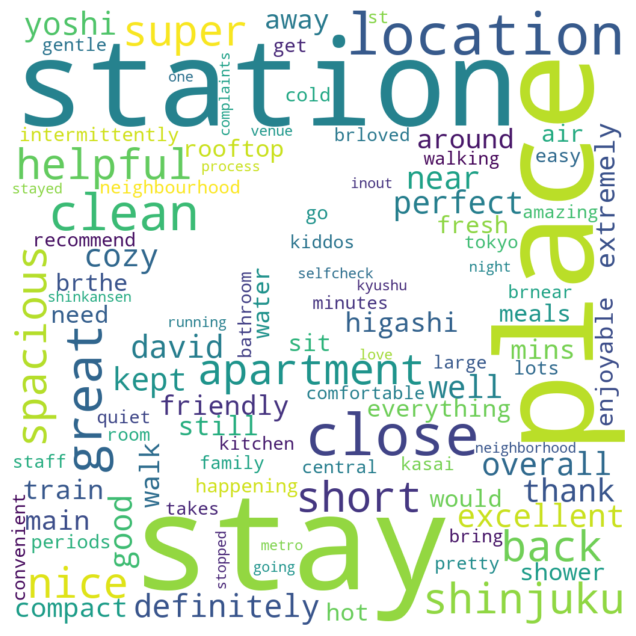

In [171]:
all_comments = ' '.join(top_10_listings_details['comments'].astype(str))
# Convert to lowercase
all_comments = all_comments.lower()
# Remove punctuation
all_comments = re.sub(r'[^\w\s]', '', all_comments)
# Remove Stopwords
stop_words = set(stopwords.words('english'))

all_comments = ' '.join([word for word in all_comments.split() if word not in stop_words])

mask_image = np.array(Image.open('images/house.png')) 
plt.figure(figsize = (8, 8), facecolor = None) 
wordcloud = WordCloud(width = 300, height = 300, 
                background_color ='white', 
                stopwords = set(), mask=mask_image,
                min_font_size = 10).generate(all_comments)
                      
plt.axis("off") 
plt.imshow(wordcloud, interpolation='bilinear') 

### **Wordcloud for amenities in top 10 listings**

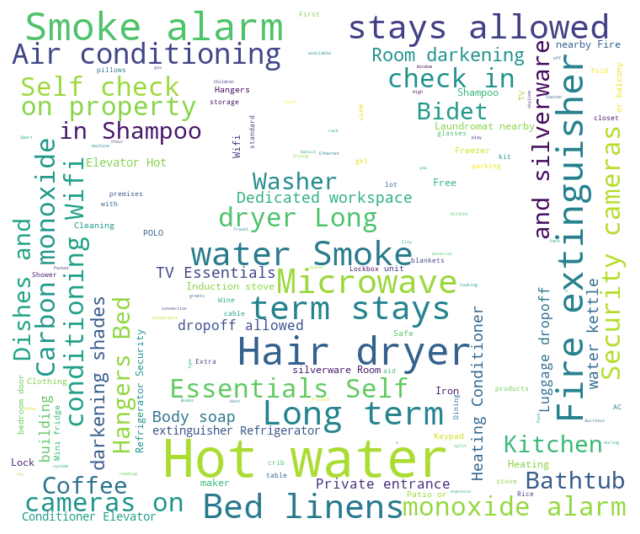

In [175]:
all_amenities = ' '.join(top_10_listings_details['amenities'].astype(str))
all_amenities = all_amenities.lower()
all_amenities = re.sub(r'[^\w\s]', '', all_amenities)
stop_words = set(stopwords.words('english'))
all_amenities = ' '.join([word for word in all_amenities.split() if word not in stop_words])
mask_image = np.array(Image.open('images/house.jpeg'))                       
plt.figure(figsize = (8, 8)) 

wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = set(), mask=mask_image, relative_scaling=0.7).generate(all_amenities_text)
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear') 

In [103]:
# Counting the frequency of each word in all_amenities
word_freq = Counter(all_amenities)

# Sorting the word counts in descending order and printing them
for word, count in word_freq.most_common():
    print(f"{word}: {count}")

Hot water: 10
Smoke alarm: 10
Essentials: 10
Heating: 10
Hair dryer: 10
Wifi: 10
Hangers: 9
Fire extinguisher: 9
Shampoo: 9
Microwave: 8
Bed linens: 8
Long term stays allowed: 8
Air conditioning: 8
Self check-in: 7
Carbon monoxide alarm: 7
Security cameras on property: 7
Elevator: 7
Kitchen: 6
Refrigerator: 6
Dishes and silverware: 6
Room-darkening shades: 6
Bathtub: 6
Dedicated workspace: 6
TV: 6
Conditioner: 6
Bidet: 6
Hot water kettle: 6
Luggage dropoff allowed: 5
Private entrance: 5
Body soap: 5
Iron: 4
Laundromat nearby: 4
Coffee: 4
Keypad: 3
Mini fridge: 3
Lock on bedroom door: 3
Safe: 3
Freezer: 3
Induction stove: 3
Washer: 3
TV with standard cable: 2
Lockbox: 2
Patio or balcony: 2
First aid kit: 2
Wine glasses: 2
Extra pillows and blankets: 2
Clothing storage: closet: 2
Rice maker: 2
Shower gel: 2
Dining table: 2
Cleaning products: 2
Free washer – In building: 1
HITACHI induction stove: 1
Free dryer – In building: 1
Pack ’n play/Travel crib: 1
Park view: 1
Cooking basics: 1
AC 

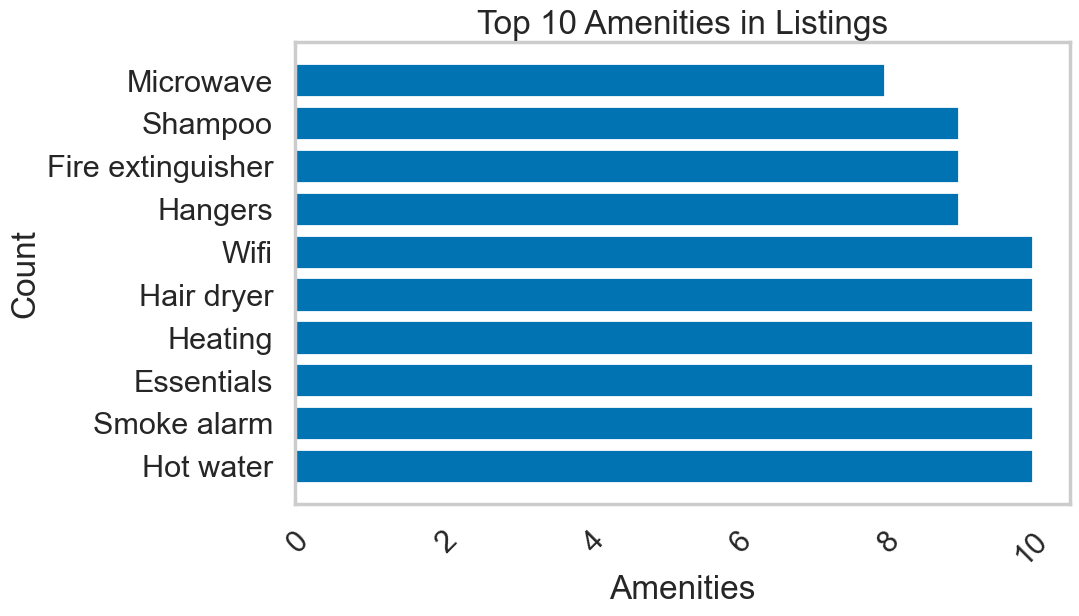

In [125]:
# Bar plot for frequent amenities
top_10_words = word_freq.most_common(10)
words, counts = zip(*top_10_words)
plt.figure(figsize=(10, 6))
plt.barh(words, counts)

plt.xlabel('Amenities')
plt.ylabel('Count')
plt.title('Top 10 Amenities in Listings')
plt.xticks(rotation=45, ha='right', wrap=True)
plt.grid(False)
plt.show()

# **Data processing for Modeling**

## Modeling with a sample for computational efficiency

In [197]:
# Select only the relevant columns and selecting a random sample
# Model crashed while running on the full data

sampled_df = df.sample(frac=0.5)
new_df = sampled_df[['reviewer_id', 'listing_id', 'rating']]

In [198]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37488 entries, 2434 to 67891
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   listing_id              37488 non-null  object        
 1   date                    37488 non-null  datetime64[ns]
 2   reviewer_id             37488 non-null  int64         
 3   reviewer_name           37488 non-null  object        
 4   comments                37483 non-null  object        
 5   listing_url             37488 non-null  object        
 6   name                    37488 non-null  object        
 7   description             37488 non-null  object        
 8   neighborhood_overview   27397 non-null  object        
 9   picture_url             37488 non-null  object        
 10  neighborhood            37488 non-null  object        
 11  latitude                37488 non-null  float64       
 12  longitude               37488 non-null  float64 

In [199]:
# Define the rating scale
reader = Reader(rating_scale=(1, 5)) 

# Load the dataset into Surprise
data = Dataset.load_from_df(new_df, reader)

In [200]:
full_dataset = data.build_full_trainset()

#view the number of users and items
print('Number of users: ', full_dataset.n_users, '\n')
print('Number of items: ', full_dataset.n_items)

Number of users:  35522 

Number of items:  6342


In [201]:
trainset, testset = train_test_split(data, test_size=0.2,random_state=42)

### Determining the best model. I'll use RMSE and MAE to evaluate the models. 

In [202]:
# function for outputting the accuracy predictions on an algorithm

def train_and_test_pred (algo, trainset, testset): 
    algo.fit(trainset)
   
    train_predictions = algo.test(trainset.build_testset())
    print('biased accuracy on train set: ')
    print(accuracy.rmse(train_predictions))
    print(accuracy.mae(train_predictions))
    test_predictions = algo.test(testset)
    print('unbiased accuracy on test set: ')
    print(accuracy.rmse(test_predictions))
    print(accuracy.mae(test_predictions))

# Baseline Model - K-Nearest Neighbors

In [203]:
baseline_model = KNNBasic()
train_and_test_pred(baseline_model, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.0000
7.783213665476095e-16
MAE:  0.0000
3.234935938107525e-16
unbiased accuracy on test set: 
RMSE: 0.1871
0.18714626477210647
MAE:  0.1459
0.14589217776068517


In [76]:
# Scores for KNN Basic via cross validation
cv_knn_basic = cross_validate(baseline_model, data)
print("mean test rmse", np.mean(cv_knn_basic['test_rmse']))
print("mean test mae", np.mean(cv_knn_basic['test_mae']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
mean test rmse 0.18689555081820294
mean test mae 0.1453630492604079


### **Interpretation**
Baseline:                           RMSE: 0.1875 MAE: 0.1459

Cross-Validation Scores Baseline:
Mean Test RMSE: 0.1869
Mean Test MAE: 0.1454

The cross-validation results are very close to the test set results of the baseline model, indicating consistency in the model's performance.

# Singular Value Decomposition (SVD)

In [204]:
# Scores for Baseline SVD Crossvalidation

svd = SVD()
cv_svd = cross_validate(svd, data)
print("mean test rmse", np.mean(cv_svd['test_rmse']))

mean test rmse 0.13230798145429107


In [206]:
train_and_test_pred(svd, trainset, testset)

biased accuracy on train set: 
RMSE: 0.1073
0.10731123781072202
MAE:  0.0816
0.08159936790408799
unbiased accuracy on test set: 
RMSE: 0.1322
0.13216055681199318
MAE:  0.0958
0.09584130939812488


* Gridsearch with SVD

In [207]:
params = {
    'n_factors': [100,150,200],
    'n_epochs': [20,80,100],
    'lr_all': [0.008,0.01],
    'reg_all': [0.07,0.1]
}

SVD_grid = GridSearchCV(SVD, param_grid = params, n_jobs=-1, cv=5)
SVD_grid.fit(data)

In [208]:
# View grid search results
print(SVD_grid.best_params)
print(SVD_grid.best_score)

{'rmse': {'n_factors': 100, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.07}, 'mae': {'n_factors': 100, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.07}}
{'rmse': 0.09565082535915165, 'mae': 0.06596346997700288}


In [210]:
# Choose the best algo
svd_best_algo = SVD_grid.best_estimator['rmse']

In [211]:
train_and_test_pred(svd_best_algo, trainset, testset)

biased accuracy on train set: 
RMSE: 0.0093
0.0092657160132869
MAE:  0.0071
0.007064034532363254
unbiased accuracy on test set: 
RMSE: 0.0937
0.09373292669061517
MAE:  0.0652
0.06515042992988555


In [212]:
#Scores for Best SVD via cross validation
cv_best_svd = cross_validate(svd_best_algo, data)
print("mean test rmse", np.mean(cv_best_svd['test_rmse']))
print("mean test mae", np.mean(cv_best_svd['test_mae']))

mean test rmse 0.09545286047537957
mean test mae 0.06576929189494977


## Interpretation

Average RMSE is 0.095. The tuned SVD model shows an improvement in predictive accuracy over the baseline SVD model, as shown by lower RMSE and MAE scores.

# KNN Basic

* Pearson Similarity

In [213]:
# Scores for Baseline KNNBasic Crossvalidation
# item based filtering
knn_basic = KNNBasic(sim_options={"name": 'pearson', 'user_based':False})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
print("mean test rmse", np.mean(cv_knn_basic['test_rmse']))

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
mean test rmse 0.18635284747607897


In [214]:
train_and_test_pred(knn_basic, trainset, testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.0000
0.0
MAE:  0.0000
0.0
unbiased accuracy on test set: 
RMSE: 0.1872
0.1871756774280846
MAE:  0.1460
0.14595451684748487


In [215]:
# GridSearch with KNNBasic
params = {
    'k': [20,40,60],
    'sim_options': {
        'name':['msd', 'cosine', 'pearson'],
        'user_based': [False]   
    }
}
KNNBasic_grid = GridSearchCV(KNNBasic, param_grid = params, cv=5, n_jobs=-1)
KNNBasic_grid.fit(data)

Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
C

In [216]:
# view grid search results
print(KNNBasic_grid.best_params)
print(KNNBasic_grid.best_score)

{'rmse': {'k': 20, 'sim_options': {'name': 'pearson', 'user_based': False}}, 'mae': {'k': 20, 'sim_options': {'name': 'pearson', 'user_based': False}}}
{'rmse': 0.18620947768679916, 'mae': 0.14501093647967075}


In [217]:
# take the best model and 
# test on train/test 
KNNbasic_best_algo = KNNBasic_grid.best_estimator['rmse']
train_and_test_pred(KNNbasic_best_algo, trainset, testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.0000
0.0
MAE:  0.0000
0.0
unbiased accuracy on test set: 
RMSE: 0.1872
0.1871756774280846
MAE:  0.1460
0.14595451684748487


In [218]:
# Scores for Best KNNbasic via cross validation
cv_best_knnbasic = cross_validate(KNNbasic_best_algo, data)
print(np.mean(cv_best_knnbasic['test_rmse']))
print(np.mean(cv_best_knnbasic['test_mae']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
0.18634348709573895
0.1450852577860553


# KNN Baseline

In [219]:
# view our cross validation score with KNNBaseline:
knn_baseline = KNNBaseline(sim_options={"name": 'pearson', 'user_based':False})
cv_knn_baseline = cross_validate(knn_baseline, data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [220]:
train_and_test_pred(knn_baseline, trainset, testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
biased accuracy on train set: 
RMSE: 0.0000
7.928863374242852e-17
MAE:  0.0000
7.078180803878958e-18
unbiased accuracy on test set: 
RMSE: 0.1322
0.1322085647899064
MAE:  0.0973
0.0973412772125856


# NMF

In [222]:
#Baseline NMF cross validation scores
nmf = NMF()

cv_nmf = cross_validate(nmf, data)
print(np.mean(cv_nmf['test_rmse']))
print(np.mean(cv_nmf['test_mae']))

0.334457700422259
0.20646366010873013


In [223]:
## GridSearch with NMF
## note: this took 11 minutes to run
params = {
    'n_factors': [10,15,20,25,30],
    "n_epochs": [25,50,75,100],
    "reg_pu": [0.06,0.1],
    "reg_qi": [0.06,0.1]
}
nmf_grid = GridSearchCV(NMF, param_grid = params, cv=5)
nmf_grid.fit(data)

In [224]:
#view grid search results
print(nmf_grid.best_params)
print(nmf_grid.best_score)

{'rmse': {'n_factors': 10, 'n_epochs': 25, 'reg_pu': 0.06, 'reg_qi': 0.06}, 'mae': {'n_factors': 10, 'n_epochs': 25, 'reg_pu': 0.06, 'reg_qi': 0.1}}
{'rmse': 0.20489869558486823, 'mae': 0.15642856244524062}


In [225]:
#take the best model and 
#test on train/test 
nmf_best = nmf_grid.best_estimator['rmse']
train_and_test_pred(nmf_best, trainset, testset)

biased accuracy on train set: 
RMSE: 0.3248
0.3247817233486416
MAE:  0.2727
0.272693962390558
unbiased accuracy on test set: 
RMSE: 0.2060
0.20596748778905147
MAE:  0.1567
0.1567401367961113


In [226]:
#Scores for Best NMF via cross validation
cv_best_nmf = cross_validate(nmf_best, data)
print("mean test rmse", np.mean(cv_best_nmf['test_rmse']))

mean test rmse 0.20707696566695635


### Interpretation - 
Highest RMSE among the models tested. Overall still very low but other models performed better

# Comparing Models

In [ ]:
KNNBaseline 0.099
KNNBasic 0.13
SVD 0.095
NMF 0.206

SVD has the lowest RMSE 0.096 and is the best among the models tested

# Making simple predictions

In [59]:
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20230924051543,2023-09-24,city scrape,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.83,4.53,4.79,M130003350,f,1,1,0,0,1.19
1,5240174,https://www.airbnb.com/rooms/5240174,20230924051543,2023-09-24,previous scrape,Rental unit in Shibuya-ku · ★4.52 · Studio · 1...,Minimalist simple grey-color interior room. My...,NaN,https://a0.muscache.com/pictures/b0b55fef-80cb...,24477517,...,4.83,4.29,4.30,M130005396,t,4,4,0,0,1.89
2,5262640,https://www.airbnb.com/rooms/5262640,20230924051543,2023-09-24,city scrape,Rental unit in Nakano-ku · ★4.80 · 1 bedroom ·...,It takes 5 min walk to Fujimidai Sta.. You can...,No smoking in the room<br />No outdoor shoes a...,https://a0.muscache.com/pictures/281f8d6f-eb4a...,17736560,...,4.87,4.61,4.77,Hotels and Inns Business Act | 中野区保健所 | 30中環生環...,f,9,9,0,0,0.59
3,776070,https://www.airbnb.com/rooms/776070,20230924051543,2023-09-24,city scrape,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,...,4.98,4.84,4.91,M130000243,f,1,0,1,0,1.88
4,905944,https://www.airbnb.com/rooms/905944,20230924051543,2023-09-24,city scrape,Rental unit in Shibuya · ★4.77 · 2 bedrooms · ...,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/miso/Hosting-...,4847803,...,4.91,4.78,4.78,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,5,5,0,0,1.52


In [84]:
best_model = SVD(n_factors= 100, n_epochs= 100, lr_all= 0.01, reg_all=0.1)
best_model.fit(trainset)

In [85]:
best_model.test(testset)
accuracy.rmse(best_model.test(testset))

RMSE: 0.0965


0.09654918021099558

In [60]:
best_model.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=4.72041947315772, details={'was_impossible': False})

In [87]:
df.head()

,listing_id,date,reviewer_id,reviewer_name,comments,listing_url,name,description,neighborhood_overview,picture_url,...,bathrooms_text,bedrooms,beds,amenities,price,has_availability,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,rating
0,197677,2023-05-05,80161764,Sabrina,"Friendly welcome, well equiped accomodation. E...",https://www.airbnb.com/rooms/197677,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,...,1 bath,1.0,2.0,"[""Microwave"", ""Hangers"", ""Kitchen"", ""Fire exti...","$12,000.00",t,174,8,0,4.77
1,197677,2023-05-30,14533360,Liang-Pin,Marek is a very friendly host. He was very kin...,https://www.airbnb.com/rooms/197677,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,...,1 bath,1.0,2.0,"[""Microwave"", ""Hangers"", ""Kitchen"", ""Fire exti...","$12,000.00",t,174,8,0,4.77
2,197677,2023-08-13,390831971,Ainsley,It is a nice and peaceful location and totally...,https://www.airbnb.com/rooms/197677,Rental unit in Sumida · ★4.77 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,...,1 bath,1.0,2.0,"[""Microwave"", ""Hangers"", ""Kitchen"", ""Fire exti...","$12,000.00",t,174,8,0,4.77
3,776070,2023-05-19,20824347,Ikuko,Keiさんのご家族はとても仲良しで、自然体で受け入れてくださり<br/>とても居心地の良い雰...,https://www.airbnb.com/rooms/776070,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,...,1 shared bath,NaN,1.0,"[""Luggage dropoff allowed"", ""Private entrance""...","$8,902.00",t,248,18,1,4.98
4,776070,2023-05-28,275284916,Jean-Daniel,It is an amazing place to stay with a japanese...,https://www.airbnb.com/rooms/776070,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,...,1 shared bath,NaN,1.0,"[""Luggage dropoff allowed"", ""Private entrance""...","$8,902.00",t,248,18,1,4.98


# Function to obtain new user ratings for properties

In [88]:
def airbnb_rater(df, num, room_type=None):
    reviewer_id = 12345678
    rating_list = []

    while num > 0:
        if room_type:
            listing = listings[listings['room_type'].str.contains(room_type)].sample(1)
        else: 
            listing = listings.sample(1)

        print(f"Name: {listing['name'].values[0]}")
        print(f"URL: {listing['listing_url'].values[0]}")
        print(f"Description: {listing['description'].values[0]}")
        print(f"Neighborhood: {listing['neighbourhood_cleansed'].values[0]}")

        # Get user rating
        rating = input('How do you rate this listing on a scale of 1-5, press n if you have not stayed here:\n')
        try:
            if 1 <= int(rating) <= 5:
                rating_listing = {'reviewer_id': reviewer_id, 'listing_id':listing['id'].values[0], 'rating': rating}
                rating_list.append(rating_listing)
                num -= 1
        except:
            print('Please enter a valid rating from 1-5')
            continue
    return rating_list

# Testing the Function

In [140]:
user_rating = airbnb_rater(listings, 5)

Name: Hotel in Taito City · ★4.72 · 1 bedroom · 3 beds · 1 private bath
URL: https://www.airbnb.com/rooms/40353195
Description: [About 4 minutes on foot from Shin Okachimachi Station] Deluxe Family Room High Floor<br /><br />Sakura Cross Hotel Ueno Okachimachi is a beautiful hotel opened in 2019 and close to the station.<br />This is a completely private hotel located in a convenient location near the station. Please use it as a base for business trips, sightseeing, expedition, etc.<br />Rooms are equipped with towels, air conditioning and flat-screen TV! The entire hotel is non-smoking.<br /><br /><b>The space</b><br />[Location]<br />Located in Tokyo, Sakura Cross Hotel Ueno Okachimachi is 400 meters from Chogoji Temple and 600 meters from Katsushika Hokusai's Tomb. Free WiFi is available. Located within 1 km from Rinko-ji Temple, a 12-minute walk from Eimi-ji Temple and 1 km from Choju-in Temple, this family room has accommodations.<br />Sakura Cross Hotel Ueno Okachimachi is surrou

# Making predictions with the New Ratings

In [141]:
user_ratings = pd.DataFrame(user_rating)
new_ratings_df = pd.concat([new_df, user_ratings], axis=0)

# Load into Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_ratings_df, reader)

#data = Dataset.load_from_df(new_ratings_df[['userId', 'listingId', 'rating']], reader)

In [142]:
svd_ = SVD(n_factors= 100, n_epochs= 100, lr_all= 0.01, reg_all=0.1)
svd_.fit(data.build_full_trainset())

In [143]:
# Make predictions for the new user
list_of_listings = []
for l_id in new_ratings_df['listing_id'].unique():
    list_of_listings.append( (l_id, svd_.predict(12345678, l_id)[3]))

In [144]:
# order the predictions from highest to lowest rated
ranked_listings = sorted(list_of_listings, key=lambda x:x[1], reverse=True)

In [145]:
ranked_listings

[('29947521', 4.49813312498016),
 ('908974948897403972', 4.481085827923736),
 ('15996058', 4.477877692120545),
 ('53517793', 4.477454922764396),
 ('47151937', 4.47330187887083),
 ('14767582', 4.458115936959491),
 ('868649575898529585', 4.456052515946353),
 ('909834219389134686', 4.455634511262416),
 ('840986436606857778', 4.4528381855056125),
 ('53184285', 4.4470191142117255),
 ('36078326', 4.441527982754222),
 ('41052297', 4.441406467650735),
 ('847683786784272384', 4.440197205492927),
 ('42647709', 4.438559495335293),
 ('32751483', 4.438262773086884),
 ('21967977', 4.437855046118025),
 ('513589842177328168', 4.4371065980403),
 ('756918768955337517', 4.437011229693133),
 ('622075093082884020', 4.4344645201008595),
 ('39773166', 4.433685355667728),
 ('48611867', 4.433604300019927),
 ('54187323', 4.433514631021421),
 ('35339109', 4.431588258742993),
 ('881011850336365423', 4.4304352554658),
 ('722141459996913452', 4.430246412446365),
 ('11167120', 4.4301896889803105),
 ('40387940', 4.42

In [146]:
# return the top n recommendations
def recommended_listings(user_ratings, listing_title_df,n):
    for idx, rec in enumerate(user_ratings):
        id = listing_title_df.loc[listing_title_df['id'] == int(rec[0])]['id', 'description']
        n -= 1
        #print('Recommendation # ', idx+1, ': ', id, '\n')
        #n-= 1
        #if n == 0:
            #break

In [147]:
def recommended_listings(user_ratings, listing_title_df, n):
    for idx, rec in enumerate(user_ratings):
        # We need to pass a list of column names, not a tuple
        listing_info = listing_title_df.loc[listing_title_df['id'] == int(rec[0]), ['id', 'description']]
        
        # If the listing is found, print the ID and description
        if not listing_info.empty:
            # Get the listing ID and description from the DataFrame
            listing_id = listing_info['id'].iloc[0]
            description = listing_info['description'].iloc[0]
            print(f'Recommendation # {idx+1}: ID {listing_id}, Description: {description}\n')
        else:
            print(f'Listing ID {rec[0]} not found in DataFrame.')
        
        n -= 1
        if n == 0:
            break


# Recommender System

In [148]:
recommended_listings(ranked_listings,listings,5)

Recommendation # 1: ID 29947521, Description: Rooms are Japanese style with tatami mats, futon mattresses, and a kotatsu to keep you warm in winter.<br />The rooms are a 16-minute walk from Oizumigakuen Station, and two stops by bus. From Ikebukuro Station, take the Seibu Ikebukuro Line and get off at Oizumigakuen Station, the birthplace of anime.<br /><br />It takes about 2.5 hours from Haneda Airport or Narita Airport.<br /><br /><br />Those who make reservations on the day of the tour may be required to attend the tour online.<br /><br /><b>The space</b><br />Completely private apartment room.<br />nothing share with someone. <br />common Japanese room.<br />The kitchen is a mini kitchen with 'IH'. It is possible to make some dish etc. And there are kettle and green tea, so you can drink for free. In the room, dishes, chopsticks, tea bowls, cups etc. are also put on.<br /><br /><b>Guest access</b><br />The entrance is auto-locked.<br />The key to your room is a smart lock.<br />Room

# Actionable Recommendations for Airbnb

* Invest in entire homes or apartments , for consistent high ratings
* Include popular amenities - security, safety features and bath and kitchen essentials 
* Price the listing under $200/night 